In [1]:
TRAIN_SPLIT = 300#300000
BUFFER_SIZE = 100#10000#100#10000
BATCH_SIZE = 128#256##256
EVALUATION_INTERVAL = 2#200
EPOCHS = 10

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

dates = pd.to_datetime(pd.date_range('2018-02-13', periods=400, freq='MIN', name='date'), errors='coerce') # freq='T'
col1 = np.arange(len(dates)) * 1 # np.random.randn(len(dates))
col2 = np.array([np.sin(i/10) for i in range(1,(len(dates)+1))]) * 2 # np.random.randn(len(dates))
#col2 = np.arange(len(dates)) * 2 # np.array([np.sin(i) for i in range(1,400)])
col3 = np.array([np.sin(i/50) for i in range(1,(len(dates)+1))]) * 3 # np.random.randn(len(dates))
#col3 = np.arange(len(dates)) * 3
df = pd.DataFrame({'col1':col1,'col2':col2,'col3':col3}, index=dates)
print(df.shape)
df.head(2)


(400, 3)


,col1,col2,col3
date,,,
2018-02-13 00:00:00,0,0.199667,0.059996
2018-02-13 00:01:00,1,0.397339,0.119968


In [3]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [4]:
features_considered = ['col1', 'col2', 'col3']

In [5]:
features = df[features_considered]
features.index = df.index
features.head()

,col1,col2,col3
date,,,
2018-02-13 00:00:00,0,0.199667,0.059996
2018-02-13 00:01:00,1,0.397339,0.119968
2018-02-13 00:02:00,2,0.591040,0.179892
2018-02-13 00:03:00,3,0.778837,0.239744
2018-02-13 00:04:00,4,0.958851,0.299500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A1E5C924E0>,
      dtype=object)

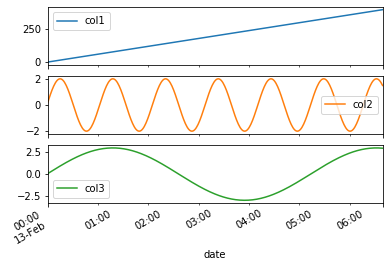

In [6]:
features.plot(subplots=True)

In [7]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [8]:
dataset = (dataset-data_mean)/data_std

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
past_history = 72#720
future_target = 7#72
STEP = 2#6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [11]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (36, 3)


In [12]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [14]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(21, 1)


In [15]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 2 steps, validate for 50 steps
Epoch 1/10
2/2 [==============================] - 2s 1s/step - loss: 0.9439 - val_loss: 1.0561
Epoch 2/10
2/2 [==============================] - 0s 94ms/step - loss: 0.9036 - val_loss: 1.1008
Epoch 3/10
2/2 [==============================] - 0s 95ms/step - loss: 0.8699 - val_loss: 1.1482
Epoch 4/10
2/2 [==============================] - 0s 94ms/step - loss: 0.8362 - val_loss: 1.1948
Epoch 5/10
2/2 [==============================] - 0s 96ms/step - loss: 0.7922 - val_loss: 1.2367
Epoch 6/10
2/2 [==============================] - 0s 94ms/step - loss: 0.7474 - val_loss: 1.3046
Epoch 7/10
2/2 [==============================] - 0s 87ms/step - loss: 0.6901 - val_loss: 1.3669
Epoch 8/10
2/2 [==============================] - 0s 90ms/step - loss: 0.6219 - val_loss: 1.4196
Epoch 9/10
2/2 [==============================] - 0s 89ms/step - loss: 0.5551 - val_loss: 1.4901
Epoch 10/10
2/2 [==============================] - 0s 89ms/step - loss: 0.4712 - val_los

In [16]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

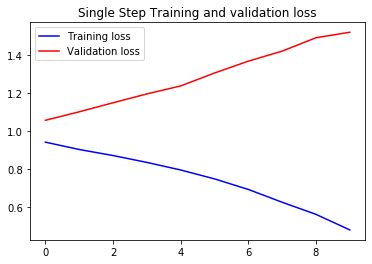

In [17]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

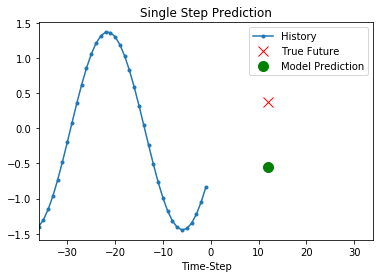

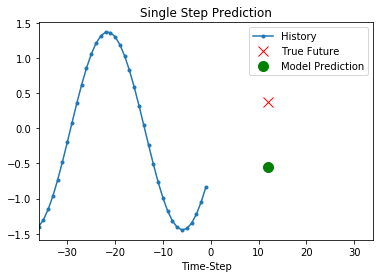

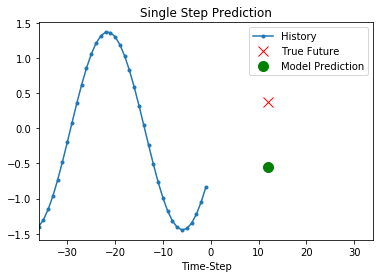

In [18]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()